### CGH reconstruction by torch

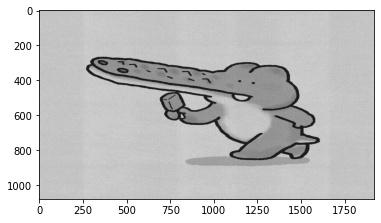

In [18]:
import cv2 as cv
import numpy as np
import torch
import matplotlib.pyplot as plt


M = 1920
N = 1080
h = 0.532 * 0.001
pix = 0.008
z0 = 800
iter = 20

LM = M * pix
LN = N * pix
n = torch.linspace(0, N - 1, N)
m = torch.linspace(0, M - 1, M)
x = -LM / 2 + LM / M * m
y = -LN / 2 + LN / N * n
xx, yy = torch.meshgrid([x, y], indexing='xy')

img = cv.imread('../save/CGH.bmp')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img = cv.resize(img, (M, N))
img = torch.tensor(img)
Phase = img.float() / 255 * 2 * torch.pi
spherical = torch.remainder(torch.pi / z0 * (xx**2+yy**2) / h, 2 * torch.pi)
phase = (Phase - spherical).reshape(1,1,N,M)

real = torch.cos(phase)
imag = torch.sin(phase)
real_fft = torch.fft.ifft2(real)
real_r = real_fft.clone().real
real_i = real_fft.clone().imag
imag_fft = torch.fft.ifft2(imag)
imag_r = imag_fft.clone().real
imag_i = imag_fft.clone().imag
ur = real_r - imag_i
ui = real_i + imag_r
U_show = (ur.square() + ui.square()).sqrt()

U_show = U_show[0, 0]
save_img = ((U_show / U_show.max()) * 255).int()
plt.imshow(save_img, 'gray')
plt.show()

### GS iter by torch, faster than numpy


100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


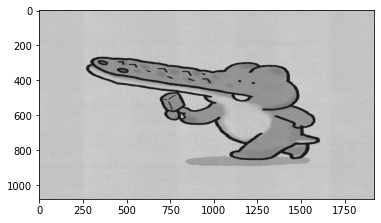

In [17]:
# GS iteration using torch.complex  

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
from operator import index
import cv2 as cv
import torch
import numpy as np
from tqdm import tqdm

M = 1920
N = 1080
h = 0.532 * 0.001
pix = 0.008
z0 = 800
iter = 20

LM = M * pix
LN = N * pix
L0 = h * z0 / pix
n = torch.linspace(0, N - 1, N)
m = torch.linspace(0, M - 1, M)
x0 = -L0 / 2 + L0 / M * m
y0 = -L0 / 2 + L0 / N * n
x_img, y_img = torch.meshgrid([x0, y0], indexing='xy')
x = -LM / 2 + LM / M * m
y = -LN / 2 + LN / N * n
x_slm, y_slm = torch.meshgrid([x, y], indexing='xy')

L_img = (x_img ** 2 + y_img ** 2) / z0
L_slm = (x_slm ** 2 + y_slm ** 2) / z0

theta_img = torch.pi / h * L_img
theta_slm = torch.pi / h * L_slm

fresnel_img = torch.complex(torch.cos(theta_img), torch.sin(theta_img))
fresnel_slm = torch.complex(torch.cos(theta_slm), torch.sin(theta_slm))

img = cv.imread('../save/1.jpg')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img = cv.resize(img, (M, N))
img = torch.tensor(img)

U_origin = img.float()
U_img = U_origin

for i in tqdm(range(iter)):
    Uf = torch.fft.fftshift(torch.fft.fft2(U_img * fresnel_img))
    Uf = Uf * fresnel_slm
    phase = torch.angle(Uf)
    
    U_slm = torch.complex(torch.cos(phase), torch.sin(phase)) / fresnel_slm
    U_img = torch.fft.ifft2(U_slm)
    U_show = abs(U_img)
    
    U_img = U_img / fresnel_img
    theta = torch.angle(U_img)
    U_img = U_origin * torch.complex(torch.cos(theta), torch.sin(theta))

save_img = (U_show / torch.max(U_show) * 255).numpy().astype(np.uint8)
save_cgh = ((phase + torch.pi) * 255 / 2 / torch.pi).numpy().astype(np.uint8)

cv.imwrite('../save/simulate.bmp', save_img)
cv.imwrite('../save/CGH.bmp', save_cgh)

plt.imshow(save_img, 'gray')
plt.show()

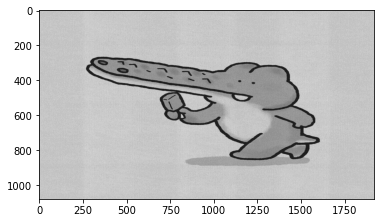

In [13]:
# torch.complex reconstruction

import cv2 as cv
import numpy as np
import torch
import matplotlib.pyplot as plt

M = 1920
N = 1080
h = 0.532 * 0.001
pix = 0.008
z0 = 800
iter = 20

LM = M * pix
LN = N * pix
L0 = h * z0 / pix
n = torch.linspace(0, N - 1, N)
m = torch.linspace(0, M - 1, M)
x0 = -L0 / 2 + L0 / M * m
y0 = -L0 / 2 + L0 / N * n
x_img, y_img = torch.meshgrid([x0, y0], indexing='xy')
x = -LM / 2 + LM / M * m
y = -LN / 2 + LN / N * n
x_slm, y_slm = torch.meshgrid([x, y], indexing='xy')

L_img = (x_img ** 2 + y_img ** 2) / z0
L_slm = (x_slm ** 2 + y_slm ** 2) / z0

theta_img = torch.pi / h * L_img
fresnel_img = torch.complex(torch.cos(theta_img), torch.sin(theta_img))

theta_slm = torch.pi / h * L_slm
fresnel_slm = torch.complex(torch.cos(theta_slm), torch.sin(theta_slm))

img = cv.imread('../save/CGH.bmp')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img = cv.resize(img, (M, N))
img = torch.tensor(img)

phase = img.float() / 255 * 2 * torch.pi
U_slm = torch.complex(torch.cos(phase), torch.sin(phase)) / fresnel_slm
U_img = torch.fft.ifft2(U_slm)
U_show = abs(U_img)
save_img = (U_show / torch.max(U_show) * 255).numpy().astype(np.uint8)
plt.imshow(save_img, 'gray')
plt.show()

### Differentiable reconstruction

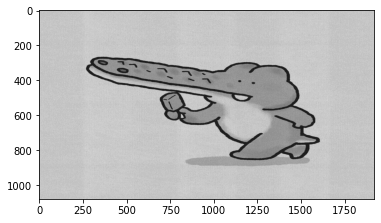

In [20]:
import cv2 as cv
import numpy as np
import torch
import matplotlib.pyplot as plt


def reconstruction(phase, spherical):
    phase = phase - spherical
    real = torch.cos(phase)
    imag = torch.sin(phase)
    real_fft = torch.fft.ifft2(real)
    real_r = real_fft.clone().real
    real_i = real_fft.clone().imag
    imag_fft = torch.fft.ifft2(imag)
    imag_r = imag_fft.clone().real
    imag_i = imag_fft.clone().imag
    ur = real_r - imag_i
    ui = real_i + imag_r
    u = (ur.square() + ui.square()).sqrt()
    return u


M = 1920
N = 1080
h = 0.532 * 0.001
pix = 0.008
z0 = 800
iter = 20

LM = M * pix
LN = N * pix
n = torch.linspace(0, N - 1, N)
m = torch.linspace(0, M - 1, M)
x = -LM / 2 + LM / M * m
y = -LN / 2 + LN / N * n
xx, yy = torch.meshgrid([x, y], indexing='xy')
spherical = torch.remainder(torch.pi / z0 * (xx**2+yy**2) / h, 2 * torch.pi)

img = cv.imread('../save/CGH.bmp')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img = cv.resize(img, (M, N))
img = torch.tensor(img)
phase = img.float() / 255 * 2 * torch.pi
phase = phase.reshape(1,1,N,M)
spherical = spherical.reshape(1,1,N,M)

U_show = reconstruction(phase, spherical)[0,0]
save_img = ((U_show / U_show.max()) * 255).int()
plt.imshow(save_img, 'gray')
plt.show()

### Differentiable diffraction and reconstruction

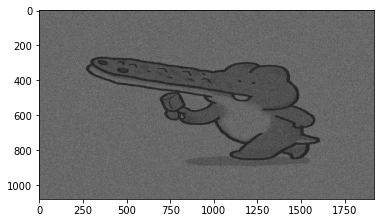

In [24]:
import cv2 as cv
import numpy as np
import torch
import matplotlib.pyplot as plt


def complex_multipy(x_real, x_imag, y_real, y_imag):
    real = x_real*y_real - x_imag*y_imag
    imag = x_real*y_imag + x_imag*y_real
    return real, imag


def diffraction(img, theta_rand, theta_img, theta_slm):
    theta_real, theta_imag = complex_multipy(
        torch.cos(theta_rand),
        torch.sin(theta_rand),
        torch.cos(theta_img),
        torch.sin(theta_img)
    )
    U_real = img * theta_real
    U_imag = img * theta_imag
    real_fft = torch.fft.fft2(U_real)
    real_r = real_fft.clone().real
    real_i = real_fft.clone().imag
    imag_fft = torch.fft.fft2(U_imag)
    imag_r = imag_fft.clone().real
    imag_i = imag_fft.clone().imag
    Uf_real = real_r - imag_i
    Uf_imag = real_i + imag_r
    Uf_real = torch.fft.fftshift(Uf_real)
    Uf_imag = torch.fft.fftshift(Uf_imag)
    Uf_real, Uf_imag = complex_multipy(
        Uf_real,
        Uf_imag,
        torch.cos(theta_slm),
        torch.sin(theta_slm)
    )
    phase = torch.atan2(Uf_imag, Uf_real)
    return phase
    
    
def reconstruction(phase, spherical):
    phase = phase - spherical
    real = torch.cos(phase)
    imag = torch.sin(phase)
    real_fft = torch.fft.ifft2(real)
    real_r = real_fft.clone().real
    real_i = real_fft.clone().imag
    imag_fft = torch.fft.ifft2(imag)
    imag_r = imag_fft.clone().real
    imag_i = imag_fft.clone().imag
    ur = real_r - imag_i
    ui = real_i + imag_r
    u = (ur.square() + ui.square()).sqrt()
    return u


M = 1920
N = 1080
h = 0.532 * 0.001
pix = 0.008
z0 = 800
iter = 20

LM = M * pix
LN = N * pix
L0 = h * z0 / pix
n = torch.linspace(0, N - 1, N)
m = torch.linspace(0, M - 1, M)
x0 = -L0 / 2 + L0 / M * m
y0 = -L0 / 2 + L0 / N * n
x_img, y_img = torch.meshgrid([x0, y0], indexing='xy')
x = -LM / 2 + LM / M * m
y = -LN / 2 + LN / N * n
x_slm, y_slm = torch.meshgrid([x, y], indexing='xy')

L_img = (x_img ** 2 + y_img ** 2) / z0
L_slm = (x_slm ** 2 + y_slm ** 2) / z0

theta_img = torch.pi / h * L_img
theta_slm = torch.pi / h * L_slm

img = cv.imread('../save/1.jpg')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img = cv.resize(img, (M, N))
img = torch.tensor(img)

theta_rand = torch.randn([N, M])

phase = diffraction(U_img, theta_rand, theta_img, theta_slm)
U_show = reconstruction(phase, theta_slm)

save_img = (U_show / torch.max(U_show) * 255).numpy().astype(np.uint8)
save_cgh = ((phase + torch.pi) * 255 / 2 / torch.pi).numpy().astype(np.uint8)

cv.imwrite('../save/simulate.bmp', save_img)
cv.imwrite('../save/CGH.bmp', save_cgh)

plt.imshow(save_img, 'gray')
plt.show()